# 1D Spectral analysis of VERITAS data with Gammapy 

### Setup


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Check package versions
import gammapy
import numpy as np
import astropy
import regions

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.18.2
numpy: 1.19.4
astropy 4.1
regions 0.4


In [3]:
from pathlib import Path
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
    FluxPointsDataset,
)
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.visualization import plot_spectrum_datasets_off_regions

### Loading Data

In [4]:
datastore = DataStore.from_dir("$GAMMAPY_DATA")
obs_ids = [64080, 64081, 64082, 64083]
observations = datastore.get_observations(obs_ids)

No HDU found matching: OBS_ID = 64080, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 64081, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 64082, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 64083, HDU_TYPE = bkg, HDU_CLASS = None


### Defining Target Region

In [5]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

### Creating exclusion mask

We will use the reflected regions method to place off regions to estimate the background level in the on region.
To make sure the off regions don't contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there's only one known gamma-ray source near the Crab nebula: the AGN called [RGB J0521+212](http://gamma-sky.net/#/cat/tev/23) at GLON = 183.604 deg and GLAT = -8.708 deg.

In [6]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
exclusion_mask = Map.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)
exclusion_mask.data = mask
#exclusion_mask.plot();

### Running data reduction chain

 - configuration of the maker classes:

In [7]:
e_reco = MapAxis.from_energy_bounds(0.1, 30, 20, unit="TeV", name="energy")
e_true = MapAxis.from_energy_bounds(
    0.05, 100, 200, unit="TeV", name="energy_true"
)
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

In [8]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [9]:
%%time
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

CPU times: user 14.7 s, sys: 72.9 ms, total: 14.7 s
Wall time: 15.1 s


### Plotting off regions

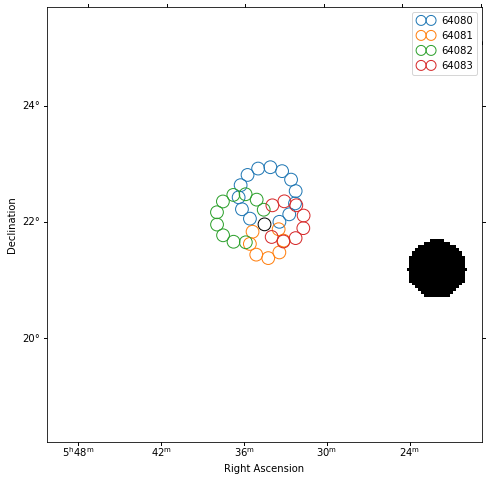

In [10]:
plt.figure(figsize=(8, 8))
_, ax, _ = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

### Source statistic

Next we're going to look at the overall source statistics in our signal region.

In [11]:
info_table = datasets.info_table(cumulative=True)

In [12]:
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str5,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
64080,183.0,10.538461538461538,172.46153846153845,23.435482399945528,22.857142857142854,22.857142857142854,nan,12.452619722457348,154369037.1168514,1013.3333005282775,1201.8021302819252,0.1805921111095404,0.010399797907527127,0.17019231320201328,20,18,wstat,577.5673183221645,137.0,18.0,234.0,0.07692307692307693
64080,351.0,18.25274658203125,332.74725341796875,32.307498832715375,47.84060623008153,47.84060623008153,nan,12.452619722457348,320025429.49067855,2027.4102266012342,2403.686617165804,0.17312727113368617,0.009002986343138997,0.1641242847905472,20,18,wstat,1101.546893655389,191.0,18.0,188.35520935058594,0.0954001322388649
64080,506.0,24.852746963500977,481.1472473144531,39.11558043498012,68.167615188625,68.167615188625,nan,12.452619722457348,476481326.70273733,3032.78274616505,3605.5122197270393,0.1668434709475436,0.008194700723263889,0.15864876833754848,20,18,wstat,1597.470861030191,257.0,18.0,186.13636779785156,0.09741399437189102
64080,681.0,32.102745056152344,648.8972778320312,45.3935420630811,93.56099876080539,93.56099876080539,nan,12.452619722457348,642180045.8265678,4047.026153101484,4807.312323898077,0.16827170723325027,0.007932428366332657,0.16033928452247376,20,18,wstat,2131.176716997915,315.0,18.0,176.6204071044922,0.10172095894813538


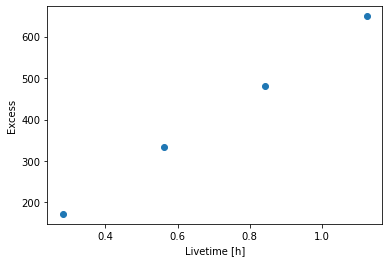

In [13]:
plt.plot(
    info_table["livetime"].to("h"), info_table["excess"], marker="o", ls="none"
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess");

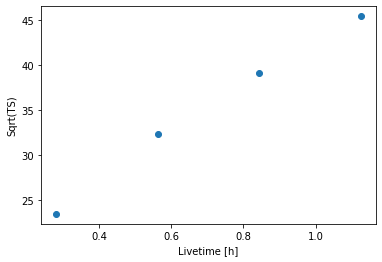

In [14]:
plt.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Sqrt(TS)");

Finally you can write the extrated datasets to disk using the OGIP format (PHA, ARF, RMF, BKG, see [here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/ogip/index.html) for details):

In [15]:
path = Path("spectrum_analysis")
path.mkdir(exist_ok=True)

In [16]:
for dataset in datasets:
    dataset.to_ogip_files(outdir=path, overwrite=True)

/home/sonal/miniconda2/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/sonal/miniconda2/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/sonal/miniconda2/envs/gammapy-0.18.2/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 

If you want to read back the datasets from disk you can use:

In [17]:
datasets = Datasets()
for obs_id in obs_ids:
    filename = path / f"pha_obs{obs_id}.fits"
    datasets.append(SpectrumDatasetOnOff.from_ogip_files(filename))

## Fitting spectrum

Now we'll fit a global model to the spectrum by stacking the observations. 

### Stack observations

Fitting the spectrum by stacking all observations first and the fitting a model. 

In [18]:
dataset_stacked = Datasets(datasets).stack_reduce()

Set the model on the dataset we would like to fit and pass it to the `~gammapy.modeling.Fit` object:

In [19]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model, name="crab")

dataset_stacked.models = model
stacked_fit = Fit([dataset_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model.copy()

In [20]:
print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 44
	total stat : 59.20



In [21]:
model_best_stacked.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.5444e+00,,nan,nan,False,5.707e-02
amplitude,2.3256e-11,cm-2 s-1 TeV-1,nan,nan,False,1.364e-12
reference,1.0000e+00,TeV,nan,nan,True,0.000e+00


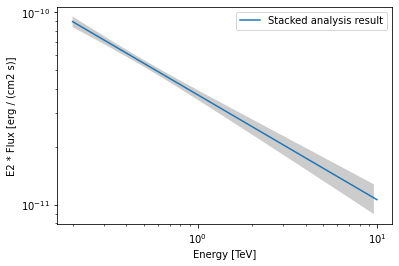

In [22]:
plot_kwargs = {
    "energy_range": [0.2, 10] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
model_best_stacked.spectral_model.plot_error(**plot_kwargs)


plt.legend()

### Computing Flux Points

- Compute flux points by fitting the norm of the global model in energy bands. We'll use a fixed energy binning for now
- Create an instance of the ~gammapy.estimators.FluxPointsEstimator, by passing the dataset and the energy binning
- the table of the resulting flux points

In [23]:
e_min, e_max = 0.2, 10
energy_edges = np.logspace(np.log10(e_min), np.log10(e_max), 13) * u.TeV


fpe = FluxPointsEstimator(energy_edges=energy_edges, source="crab")
flux_points = fpe.run(datasets=dataset_stacked)


flux_points.table_formatted

counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
181,0.235,0.177,0.313,9.237e-10,1.280e-10,2.928e-11,5.113e-11,0.830,30.515,True,0.069,384.531,0.071,0.068,0.976,0.200 .. 5.000,184.681 .. 1037.972,19.609,7.666e-10,9.013e-10,6.420e-11,6.577e-11,6.265e-11
139,0.361,0.313,0.416,3.111e-10,3.227e-11,1.156e-11,4.051e-11,1.077,0.000,True,0.096,421.451,0.099,0.093,1.280,0.200 .. 5.000,191.188 .. 548.355,20.529,3.350e-10,3.982e-10,2.988e-11,3.073e-11,2.905e-11
117,0.480,0.416,0.554,1.506e-10,2.077e-11,9.901e-12,3.468e-11,1.145,0.000,True,0.110,387.092,0.113,0.106,1.378,0.200 .. 5.000,179.229 .. 422.201,19.675,1.724e-10,2.075e-10,1.652e-11,1.703e-11,1.602e-11
101,0.638,0.554,0.736,7.287e-11,1.337e-11,8.477e-12,2.969e-11,1.338,0.000,True,0.135,386.787,0.140,0.131,1.627,0.200 .. 5.000,191.160 .. 280.038,19.667,9.751e-11,1.186e-10,9.866e-12,1.020e-11,9.543e-12
58,0.849,0.736,0.979,3.527e-11,8.609e-12,7.258e-12,2.542e-11,1.046,0.000,True,0.142,190.222,0.148,0.136,1.356,0.200 .. 5.000,83.164 .. 245.901,13.792,3.690e-11,4.781e-11,5.012e-12,5.233e-12,4.796e-12
36,1.129,0.979,1.302,1.707e-11,5.542e-12,6.214e-12,2.177e-11,0.955,0.000,True,0.163,132.093,0.172,0.154,1.317,0.200 .. 5.000,50.265 .. 180.716,11.493,1.630e-11,2.248e-11,2.777e-12,2.933e-12,2.625e-12
18,1.502,1.302,1.732,8.262e-12,3.568e-12,5.320e-12,1.864e-11,0.730,0.000,True,0.175,69.466,0.189,0.162,1.138,0.200 .. 5.000,19.137 .. 138.158,8.335,6.035e-12,9.402e-12,1.448e-12,1.564e-12,1.337e-12
18,2.304,1.732,3.064,2.782e-12,3.775e-12,8.455e-12,1.476e-11,0.705,0.000,True,0.167,79.390,0.180,0.154,1.093,0.200 .. 5.000,19.128 .. 147.859,8.910,1.960e-12,3.041e-12,4.648e-13,5.020e-13,4.290e-13


Now we plot the flux points and their likelihood profiles. For the plotting of upper limits we choose a threshold of TS < 4.

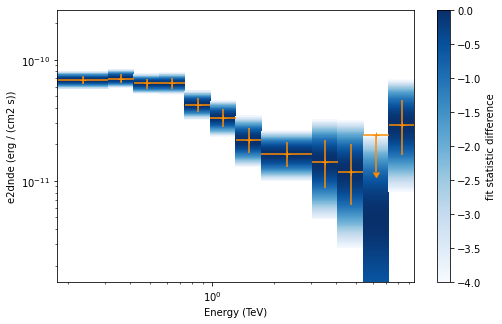

In [24]:
plt.figure(figsize=(8, 5))
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax);

The final plot with the best fit model, flux points and residuals can be quickly made like this:

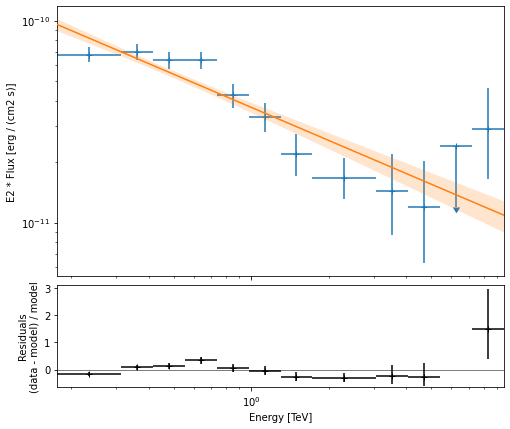

In [25]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_stacked
)

flux_points_dataset.plot_fit();